In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer.pitch import Pitch, add_image
from matplotlib.colors import to_rgba
import seaborn as sns
from PIL import Image
from urllib.request import urlopen
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib import colorbar

In [20]:
# load the image
#image_url = 
image = Image.open("Biss.png")

# load the image
image_url = "https://upload.wikimedia.org/wikipedia/en/thumb/f/fd/Brighton_%26_Hove_Albion_logo.svg/400px-Brighton_%26_Hove_Albion_logo.svg.png"
image2 = Image.open(urlopen(image_url))

In [21]:
# Ask about adding in assists, progressive passes, and shot creating passes
# Read in data

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", None)

df = pd.read_csv("Bissouma Test.csv")

#Import EPV
epv = pd.read_csv("EPV_grid.csv", header=None)
epv = np.array(epv)
epv_rows, epv_cols = epv.shape

#Import xT
xT = pd.read_csv("Expected_Threat.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

# Renaming the column for easier reference and filtering df for only passes from Bissouma
df = df.rename(columns={"type/displayName":"type", "outcomeType/displayName":"outcome"})
hmap = df[df["playerId"]==303096]
passes = df[df["type"]=="Pass"]
playerPass = passes[passes["playerId"]==303096]
playerPass = playerPass.reset_index()
print(playerPass.head(15))

    index          id  eventId  minute  second  ...  \
0      17  2249284243       12       0    35.0  ...   
1      25  2249284463       18       0    56.0  ...   
2      41  2249285237       31       2    13.0  ...   
3      45  2249285465       35       2    33.0  ...   
4      51  2249285617       41       2    47.0  ...   
5      57  2249285797       47       3     8.0  ...   
6      68  2249286361       56       4     0.0  ...   
7      92  2249287375       74       5    30.0  ...   
8     102  2249287687       81       5    57.0  ...   
9     119  2249288371       92       7    16.0  ...   
10    167  2249290319      117      10    47.0  ...   
11    169  2249290379      119      10    54.0  ...   
12    177  2249290561      127      11    13.0  ...   
13    189  2249290841      139      11    49.0  ...   
14    202  2249291231      145      12    28.0  ...   

    qualifiers/13/type/displayName  qualifiers/13/value  isGoal  \
0                              NaN                  

In [22]:
#Bin Data for EPV
playerPass['x1_bin'] = pd.cut(playerPass['x'], bins=epv_cols, labels=False)
playerPass['x2_bin'] = pd.cut(playerPass['endX'], bins=epv_cols, labels=False)
playerPass['y1_bin'] = pd.cut(playerPass['y'], bins=epv_rows, labels=False)
playerPass['y2_bin'] = pd.cut(playerPass['endY'], bins=epv_rows, labels=False)

#Return Bin Values for EPV
playerPass['start_zone_value'] = playerPass[['x1_bin', 'y1_bin']].apply(lambda x: epv[x[1]][x[0]], axis=1)
playerPass['end_zone_value'] = playerPass[['x2_bin', 'y2_bin']].apply(lambda x: epv[x[1]][x[0]], axis=1)


#Calculate Difference
playerPass['epv'] = playerPass['end_zone_value'] - playerPass['start_zone_value']

#Remove Bin Columns
playerPass = playerPass[[col for col in playerPass.columns if "bin" not in col]]

In [23]:
playerPass = playerPass.filter(["x", "y", "endX", "endY", "outcome", "epv"], axis=1)
playerPass.head(30)

,x,y,endX,endY,outcome,epv
0,70.2,29.2,64.7,11.7,Successful,-0.0088
1,41.9,35.2,41.5,66.0,Successful,0.0013
2,48.2,8.2,45.7,2.9,Successful,0.0003
3,63.7,8.2,46.8,34.0,Successful,-0.0020
4,43.3,32.8,34.2,58.5,Successful,-0.0006
5,65.5,27.4,69.8,49.0,Successful,0.0036
6,66.0,28.6,92.3,100.0,Unsuccessful,0.0167
7,33.2,6.7,24.5,4.3,Successful,0.0000
8,58.7,66.0,98.0,94.5,Successful,0.0270
9,53.0,5.0,100.0,31.3,Unsuccessful,0.0516


In [24]:
### Bin the data according to the shape of the loaded xT array
###assuming 100 is the upper maximum limit
playerPass['x1_bin'] = playerPass.x.apply(lambda val: int(val/(100/xT_cols)) if val != 100 else int(val/(100/xT_cols)) - 1 )
playerPass['x2_bin'] = playerPass.endX.apply(lambda val: int(val/(100/xT_cols)) if val != 100 else int(val/(100/xT_cols)) - 1 )

playerPass['y1_bin'] = playerPass.y.apply(lambda val: int(val/(100/xT_rows)) if val != 100 else int(val/(100/xT_rows)) - 1 )
playerPass['y2_bin'] = playerPass.endY.apply(lambda val: int(val/(100/xT_rows)) if val != 100 else int(val/(100/xT_rows)) - 1 )

### Now we just loop over every row and get correspoding xT value for the pass's start and end bins
playerPass['start_zone_value2'] = playerPass[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
playerPass['end_zone_value2'] = playerPass[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

playerPass['xT'] = playerPass['end_zone_value2'] - playerPass['start_zone_value2']

##remove the bins/indices since they're useless now
playerPass = playerPass[[col for col in playerPass.columns if 'bin' not in col]] 

In [25]:
playerPass = playerPass.filter(["x", "y", "endX", "endY", "outcome", "xT"], axis=1)
playerPassEPV = playerPass.filter(["x", "y", "endX", "endY", "outcome", "epv", "xT"], axis=1)

successful = playerPass[playerPass["outcome"]=="Successful"]
successful = successful[successful["xT"]>0]

unsuccessful = playerPass[playerPass["outcome"]=="Unsuccessful"]
unsuccessful = unsuccessful[unsuccessful["xT"]>0]

successful
#successful.xT.max()

,x,y,endX,endY,outcome,xT
5,65.5,27.4,69.8,49.0,Successful,0.004500
8,58.7,66.0,98.0,94.5,Successful,0.018575
12,71.6,36.4,82.7,10.0,Successful,0.003441
15,36.6,42.4,42.1,14.9,Successful,0.001219
21,58.1,64.8,70.7,86.8,Successful,0.007159
29,48.1,52.2,55.0,68.1,Successful,0.002010
30,65.7,34.8,68.4,46.7,Successful,0.004500
32,38.3,48.7,44.4,64.2,Successful,0.001665
33,46.5,68.2,95.9,72.1,Successful,0.050135
36,66.5,57.2,75.0,90.5,Successful,0.007592


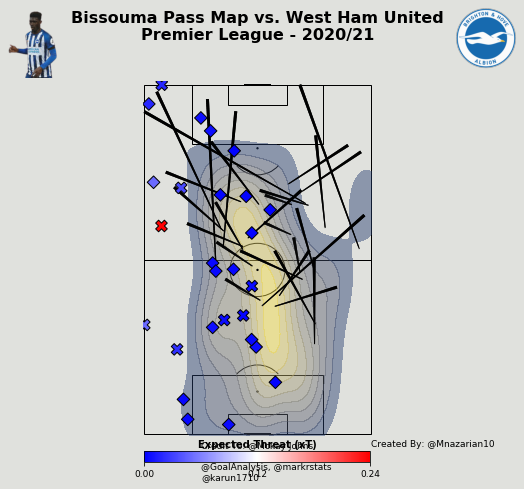

In [26]:
colmap = cm.get_cmap('coolwarm', 512)

'''#sort the df based on the xT values. Doing this plots the highest valued passes on top
successful.sort_values(by=['xT'], inplace=True, ascending=True)
#make a list of xT values
xTList = successful.xT.tolist()

#Use the minimum and maximum PV values to set the colormap
lower2 = min(xTList)
upper2 = max(xTList)
xT_norm2 = [(xTList[i]-lower2)/(upper2-lower2) for i in range(len(xTList))]
#I have orange here for the colormap I created. Replace that with the new name if you change it
colors2 = colmap(xT_norm2)'''

# What does this do? look into subplots to plot multiple pitches
fig,ax = plt.subplots(figsize=(13.5, 8))
fig.set_facecolor('#e0e1dd')
ax.patch.set_facecolor('#e0e1dd')

pitch = Pitch(pitch_type='opta', orientation='vertical', pad_top = 15,
              pitch_color='#e0e1dd', line_color='black', figsize=(16, 11),
              constrained_layout=True, tight_layout=False, linewidth=1)

pitch.draw(ax=ax)

#Ask about stopping excessive spillover of heatmap on and beyond pitch lines
# Create the heatmap
kde = sns.kdeplot(
    hmap["x"],
    hmap["y"],
    shade= True,
    shade_lowest= False,
    alpha= 0.45,
    n_levels= 11,
    #fill = True,
    #thresh=0,
    #levels=100,
    cmap= "cividis"
)

#Stop excess spill over from heatmap
ax.set_xlim(-0.5,100.5)
ax.set_ylim(-0.5,101)

#b1 = playerPassEPV.epv
b1 = successful.xT
b2 = unsuccessful.xT

complete_passes = pitch.lines(successful.x, successful.y, 
                          successful.endX, successful.endY, comet=True, lw=3, color="black", ax=ax, zorder=1)
comp_scat = plt.scatter(successful.endX, successful.endY, c=b1, alpha=1, zorder=2, 
                        vmin=0, vmax=0.24, cmap="bwr", edgecolors = "black", s=80, marker="D")

incomplete_pass = pitch.lines(unsuccessful.x, unsuccessful.y, 
                          unsuccessful.endX, unsuccessful.endY, comet=True, lw=3, color="black", ax=ax, zorder=1)
incomp_scat = plt.scatter(unsuccessful.endX, unsuccessful.endY, c=b2, alpha=1, zorder=2, 
                        vmin=0, vmax=0.24, cmap="bwr", edgecolors = "black", s=135, marker="X")

plt.gca().invert_xaxis()


#add colorbar 
#PVbar = plt.colorbar(cm.ScalarMappable(cmap="coolwarm"), ax=ax, location="bottom", shrink=0.3, ticks=[], pad=0)

#Must Change these ticks for every game!
#Color Scaling
cbar = fig.colorbar(incomp_scat, orientation="horizontal",shrink=0.3, pad=0.034,
             ticks=[0,0.12, 0.24, 0.4, 0.6, 0.8, 1])
cbar.set_label('Expected Threat (xT)', fontweight="bold", color='black', size=10)
cbar.outline.set_edgecolor('black')
cbar.ax.xaxis.set_tick_params(color='black')
cbar.ax.xaxis.set_tick_params(labelcolor='black')
cbar.ax.tick_params(labelsize=9)
cbar.ax.xaxis.set_label_position('top')

        
ax.set_title("Bissouma Pass Map vs. West Ham United\nPremier League - 2020/21", 
             fontsize=16, color="black", fontweight = 'bold', y=1.1)
plt.text(0,-3.5,"Created By: @Mnazarian10", color='black', fontsize=9)
plt.text(75,-13,"Credit To: @Mckay Johns\n@maramperninety, @trevillion_\n@GoalAnalysis, @markrstats\n@karun1710", color='black', fontsize=9)


# add an image
ax_image = add_image(image, fig, left=0.255, bottom=0.885, width=0.055,
                     alpha=0.9, interpolation='hanning')
ax_image2 = add_image(image2, fig, left=0.715, bottom=0.90, width=0.065,
                     alpha=0.9, interpolation='hanning')